In [1]:
import pandas as pd
import re
from snownlp import SnowNLP
import numpy as np


In [2]:
df = pd.read_excel("/Users/wangziyi/Desktop/数据评论.xlsx")

In [3]:
print("数据形状（行数, 列数）:", df.shape)
print("\n数据列名:")
print(df.columns.tolist())
print("\n前3条数据预览:")
print(df.head(3))

数据形状（行数, 列数）: (1243, 13)

数据列名:
['max_id', '微博id', '评论页码', '评论id', '评论时间', '评论点赞数', '评论者IP归属地', '评论者姓名', '评论者id', '评论者性别', '评论者关注数', '评论者粉丝数', 'comment']

前3条数据预览:
         max_id          微博id  评论页码          评论id                评论时间  评论点赞数  \
0  1.388880e+14  5.227850e+15     1  5.227860e+15 2025-10-31 17:04:00     47   
1  1.388880e+14  5.227850e+15     1  5.227850e+15 2025-10-31 16:59:00      2   
2  1.388880e+14  5.227850e+15     1  5.227860e+15 2025-10-31 17:00:00      8   

  评论者IP归属地       评论者姓名       评论者id 评论者性别  评论者关注数 评论者粉丝数  \
0     来自浙江      娜就吃点锅巴  5949727417     女     875    256   
1     来自广东  荆棘farewell  7739631962     女     845     99   
2     来自广东       十二画er  3866724960     女     259    504   

                          comment  
0                  我也边刷边哭我适合在旁边哭丧  
1  宝宝可以推荐一下吗！！因为毕设想做这个方向！想多看多了解一下  
2            对于家里有毛孩子的人来说，真的很难想象，  


In [4]:
def clean_weibo_comment(text):
    # 处理空值/非字符串类型
    if pd.isna(text) or not isinstance(text, str):
        return ""
    # 去除URL链接
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    # 去除HTML标签（若有）
    text = re.sub(r"<.*?>", "", text)
    # 去除特殊符号、表情符号（保留中文、英文、数字）
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9\s]", "", text)
    # 去除多余空格
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
comment_column = "comment"  
df["cleaned_comment"] = df[comment_column].apply(clean_weibo_comment)

In [6]:
def analyze_sentiment(text):
    if not text:
        return np.nan, "未知"  # 空文本标记为"未知"
    s = SnowNLP(text)
    sentiment_score = round(s.sentiments, 4)  # 保留4位小数
    if sentiment_score >= 0.6:
        sentiment_label = "积极"
    elif sentiment_score <= 0.4:
        sentiment_label = "消极"
    else:
        sentiment_label = "中性"
    return sentiment_score, sentiment_label

In [7]:
print("\n正在执行情感分析...")
sentiment_results = df["cleaned_comment"].apply(analyze_sentiment)


正在执行情感分析...


In [8]:
df[["sentiment_score", "sentiment_label"]] = pd.DataFrame(
    sentiment_results.tolist(),
    index=df.index
)

In [9]:
df_cleaned = df.dropna(subset=["sentiment_score"])
print(f"\n情感分析完成！有效分析数据行数：{len(df_cleaned)}")


情感分析完成！有效分析数据行数：1181


In [10]:
print("\n情感标签分布统计:")
sentiment_count = df_cleaned["sentiment_label"].value_counts()
print(sentiment_count)
print(f"\n积极评论占比：{round(sentiment_count.get('积极', 0)/len(df_cleaned)*100, 2)}%")
print(f"消极评论占比：{round(sentiment_count.get('消极', 0)/len(df_cleaned)*100, 2)}%")
print(f"中性评论占比：{round(sentiment_count.get('中性', 0)/len(df_cleaned)*100, 2)}%")


情感标签分布统计:
sentiment_label
积极    711
消极    272
中性    198
Name: count, dtype: int64

积极评论占比：60.2%
消极评论占比：23.03%
中性评论占比：16.77%


In [11]:
output_path = "/Users/wangziyi/Desktop/工作簿4.xlsx"
df_cleaned.to_excel(output_path, index=False)
print(f"\n结果已保存至：{output_path}")
print("\n前5条完整结果预览:")
print(df_cleaned[[comment_column, "cleaned_comment", "sentiment_score", "sentiment_label"]].head())


结果已保存至：/Users/wangziyi/Desktop/工作簿4.xlsx

前5条完整结果预览:
                                             comment  \
0                                     我也边刷边哭我适合在旁边哭丧   
1                     宝宝可以推荐一下吗！！因为毕设想做这个方向！想多看多了解一下   
2                               对于家里有毛孩子的人来说，真的很难想象，   
3  我太懂这种感觉了 一个月前我的小狗意外离开了我到现在无法接受 它才三岁 我每天都在自责在哭在...   
5                                   还有开宠物医院根本看不了宠物受伤   

                                     cleaned_comment  sentiment_score  \
0                                     我也边刷边哭我适合在旁边哭丧           0.3089   
1                        宝宝可以推荐一下吗因为毕设想做这个方向想多看多了解一下           0.7885   
2                                 对于家里有毛孩子的人来说真的很难想象           0.9387   
3  我太懂这种感觉了 一个月前我的小狗意外离开了我到现在无法接受 它才三岁 我每天都在自责在哭在...           1.0000   
5                                   还有开宠物医院根本看不了宠物受伤           0.9857   

  sentiment_label  
0              消极  
1              积极  
2              积极  
3              积极  
5              积极  


In [12]:
conda install -c conda-forge wordcloud

2 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
conda install -c conda-forge jieba

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


开始情感分析...
使用字体: /System/Library/Fonts/STHeiti Medium.ttc
情感分析结果摘要
总评论数: 20
正面评论: 11 (55.0%)
中性评论: 1 (5.0%)
负面评论: 8 (40.0%)

情感得分统计:
  平均值: 0.545
  中位数: 0.750
  标准差: 0.440
  最小值: 0.000
  最大值: 1.000

前5条评论分析结果:
------------------------------------------------------------
评论 1:
  原文: 这个产品真的很好用，我非常满意，质量超出预期！...
  情感得分: 0.906
  情感标签: positive
  关键词: 真的, 很, 好, 产品, 预期

评论 2:
  原文: 服务太差了，等了很久都没人理，再也不来了。...
  情感得分: 0.000
  情感标签: negative
  关键词: 久, 人理, 都, 没, 很

评论 3:
  原文: 一般般吧，没有什么特别的感觉，普通水平。...
  情感得分: 0.506
  情感标签: neutral
  关键词: 感觉, 特别

评论 4:
  原文: 超级推荐！性价比很高，用起来非常舒服。...
  情感得分: 0.989
  情感标签: positive
  关键词: 很, 高, 价, 性, 推荐

评论 5:
  原文: 太失望了，跟描述完全不一样，浪费钱。...
  情感得分: 0.005
  情感标签: negative
  关键词: 失望, 太, 不, 描述, 钱

生成独立图表...
生成情感分布饼图...


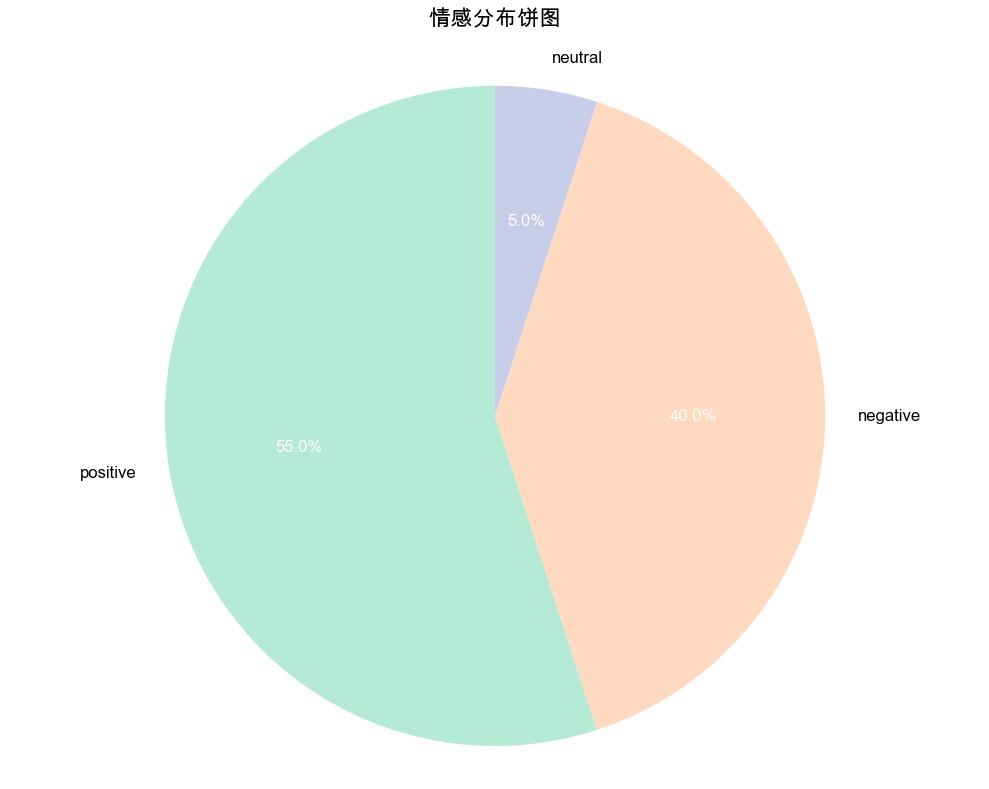

生成词云图...


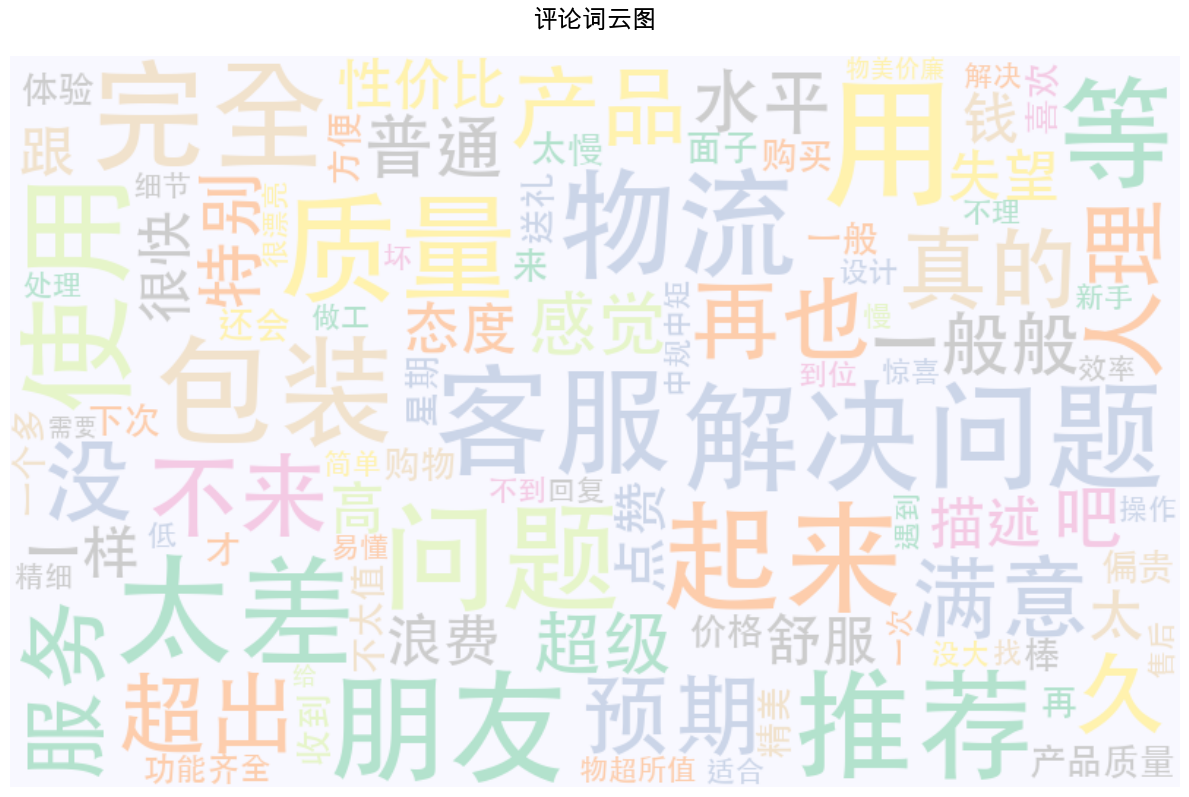

生成情感得分直方图...


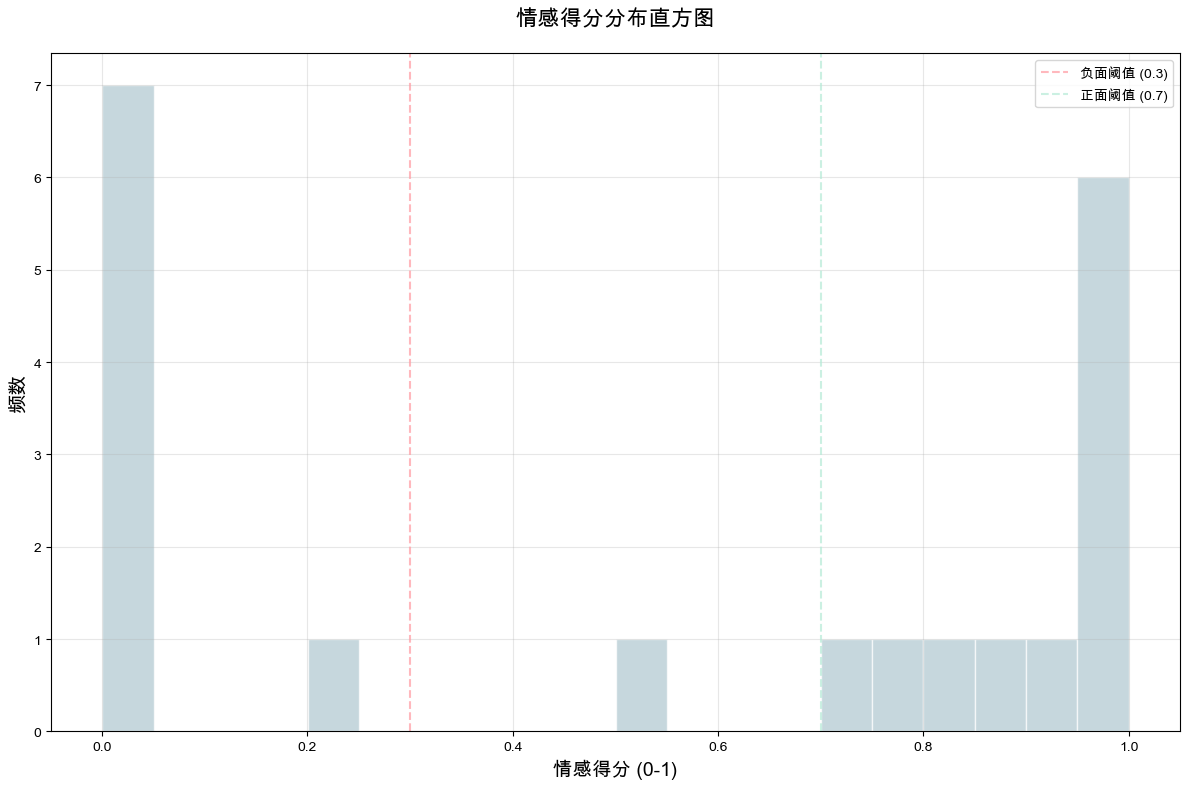

分析结果已保存到: sentiment_analysis_results.csv
图表已保存为: 情感分布饼图.png, 词云图.png, 情感得分分布直方图.png

数据预览:
   id  sentiment_score sentiment_label          keywords
0   1         0.905954        positive  真的, 很, 好, 产品, 预期
1   2         0.000480        negative    久, 人理, 都, 没, 很
2   3         0.505581         neutral            感觉, 特别
3   4         0.988531        positive    很, 高, 价, 性, 推荐
4   5         0.005266        negative   失望, 太, 不, 描述, 钱

分析完成！


In [38]:
"""
情感分析与词云图可视化(使用SnowNLP)
支持中文文本情感分析，使用淡色系配色
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from snownlp import SnowNLP
import re
import jieba
import warnings
import os
import matplotlib.font_manager as fm
warnings.filterwarnings('ignore')

# 定义淡色系配色方案
LIGHT_COLORS = {
    'positive': '#B5EAD7',  # 浅薄荷绿
    'negative': '#FFDAC1',  # 浅桃色
    'neutral': '#C7CEEA',   # 浅薰衣草紫
    'background': '#F8F8FF',  # 幽灵白背景
    'text': '#555555',       # 中灰色文字
    'accent1': '#FF9AA2',    # 浅珊瑚粉
    'accent2': '#FFB7B2',    # 浅鲑鱼粉
    'accent3': '#E2F0CB',    # 浅茶绿
    'pastel_blue': '#AEC6CF', # 浅蓝色
    'pastel_purple': '#B39EB5' # 浅紫色
}

# 示例数据 - 中文评论数据
sample_data = [
    "这个产品真的很好用，我非常满意，质量超出预期！",
    "服务太差了，等了很久都没人理，再也不来了。",
    "一般般吧，没有什么特别的感觉，普通水平。",
    "超级推荐！性价比很高，用起来非常舒服。",
    "太失望了，跟描述完全不一样，浪费钱。",
    "客服态度很好，解决问题很快，点赞。",
    "产品质量一般，价格偏贵，不太值。",
    "非常棒的购物体验，下次还会再来购买。",
    "物流太慢了，等了一个多星期才收到。",
    "包装很精美，送礼很有面子，朋友很喜欢。",
    "使用起来很方便，功能齐全，物超所值。",
    "售后完全不理人，遇到问题找不到人解决。",
    "中规中矩，没有惊喜但也没大问题。",
    "设计很漂亮，做工精细，细节处理到位。",
    "用了一次就坏了，质量太差了。",
    "操作简单易懂，适合新手使用。",
    "客服回复很慢，解决问题效率低。",
    "物美价廉，推荐给需要的朋友。",
    "与图片不符，色差很大。",
    "物流速度快，包装完好无损。"
]

def preprocess_text(text):
    """文本预处理：去除特殊字符、多余空格等"""
    if not isinstance(text, str):
        return ""
    
    # 去除特殊字符，保留中文、英文、数字和基本标点
    text = re.sub(r'[^\w\s\u4e00-\u9fff,，.。!！?？]', '', text)
    
    # 合并多个空格
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def analyze_sentiment_snownlp(text):
    """使用SnowNLP分析文本情感"""
    if not text or len(text.strip()) < 2:
        return 0.5, "neutral"
    
    try:
        s = SnowNLP(text)
        # SnowNLP的情感分析返回0-1之间的值，0为负面，1为正面
        sentiment_score = s.sentiments
        
        # 分类
        if sentiment_score > 0.7:
            sentiment_label = "positive"
        elif sentiment_score < 0.3:
            sentiment_label = "negative"
        else:
            sentiment_label = "neutral"
            
        return sentiment_score, sentiment_label
    except Exception as e:
        print(f"情感分析出错: {e}, 文本: {text[:50]}")
        return 0.5, "neutral"

def extract_keywords_snownlp(text):
    """使用SnowNLP提取关键词"""
    if not text or len(text.strip()) < 2:
        return []
    
    try:
        s = SnowNLP(text)
        keywords = s.keywords(5)  # 提取前5个关键词
        return keywords
    except:
        return []

def get_chinese_font_path():
    """获取系统中可用的中文字体路径"""
    # 尝试几种常见的中文字体路径
    font_paths = [
        'simhei.ttf',  # 黑体
        'C:/Windows/Fonts/simhei.ttf',  # Windows系统
        'C:/Windows/Fonts/msyh.ttc',    # Windows微软雅黑
        '/System/Library/Fonts/PingFang.ttc',  # macOS
        '/System/Library/Fonts/STHeiti Medium.ttc',  # macOS
        '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf',  # Linux
        '/usr/share/fonts/truetype/arphic/uming.ttc',  # Linux
    ]
    
    for font_path in font_paths:
        if os.path.exists(font_path):
            return font_path
    
    # 如果都找不到，使用matplotlib的字体管理器查找
    font_files = fm.findSystemFonts()
    for font_file in font_files:
        font_name = os.path.basename(font_file).lower()
        if any(keyword in font_name for keyword in ['hei', 'kai', 'song', 'msyh', 'pingfang', 'stsong', 'simhei']):
            return font_file
    
    return None  # 没有找到中文字体

def create_sentiment_analysis(data):
    """执行情感分析并返回结果"""
    results = []
    
    for i, text in enumerate(data):
        cleaned_text = preprocess_text(text)
        sentiment_score, sentiment_label = analyze_sentiment_snownlp(cleaned_text)
        keywords = extract_keywords_snownlp(cleaned_text)
        
        results.append({
            'id': i + 1,
            'original_text': text,
            'cleaned_text': cleaned_text,
            'sentiment_score': sentiment_score,
            'sentiment_label': sentiment_label,
            'keywords': ', '.join(keywords) if keywords else ''
        })
    
    df = pd.DataFrame(results)
    
    # 添加极性分类（用于可视化）
    df['polarity_category'] = pd.cut(
        df['sentiment_score'],
        bins=[0, 0.3, 0.7, 1.0],
        labels=['negative', 'neutral', 'positive'],
        include_lowest=True
    )
    
    return df

def generate_word_cloud(texts, stopwords=None):
    """生成词云图"""
    if stopwords is None:
        stopwords = set(STOPWORDS)
        # 添加中文停用词
        chinese_stopwords = {
            '的', '了', '在', '是', '我', '有', '和', '就', 
            '不', '人', '都', '一', '一个', '上', '也', '很', 
            '到', '说', '要', '去', '你', '会', '着', '没有', 
            '看', '好', '自己', '这', '但', '什么', '那', '就',
            '这', '那', '就', '也', '和', '与', '或', '且',
            '很', '非常', '比较', '有点', '一些', '这个', '那个',
            '这样', '那样', '这么', '那么', '怎么', '什么'
        }
        stopwords.update(chinese_stopwords)
    
    # 合并所有文本
    all_text = ' '.join([preprocess_text(t) for t in texts if isinstance(t, str)])
    
    if not all_text or len(all_text.strip()) < 10:
        print("文本内容过少，无法生成词云")
        return None
    
    # 使用jieba进行中文分词
    word_list = jieba.lcut(all_text)
    segmented_text = ' '.join(word_list)
    
    # 获取中文字体路径
    font_path = get_chinese_font_path()
    if font_path:
        print(f"使用字体: {font_path}")
    else:
        print("警告: 未找到中文字体，词云可能无法正确显示中文")
    
    # 创建词云
    wordcloud = WordCloud(
        width=800,
        height=500,
        background_color=LIGHT_COLORS['background'],
        colormap='Pastel2',  # 使用淡色系配色
        stopwords=stopwords,
        max_words=100,
        min_font_size=10,
        max_font_size=100,
        random_state=42,
        font_path=font_path  # 修改：使用动态获取的字体路径
    )
    
    wordcloud.generate(segmented_text)
    return wordcloud

def visualize_sentiment_pie(df):
    """可视化情感分布饼图（单独图表）"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    sentiment_counts = df['sentiment_label'].value_counts()
    colors = [LIGHT_COLORS.get(s, LIGHT_COLORS['neutral']) for s in sentiment_counts.index]
    
    wedges, texts, autotexts = ax.pie(
        sentiment_counts.values,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 12}
    )
    
    # 美化饼图文字
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    ax.set_title('情感分布饼图', fontsize=16, fontweight='bold', pad=20)
    ax.axis('equal')
    
    plt.tight_layout()
    plt.savefig('情感分布饼图.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return fig

def visualize_word_cloud(wordcloud):
    """可视化词云图（单独图表）"""
    if not wordcloud:
        print("无法生成词云图")
        return None
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('评论词云图', fontsize=18, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('词云图.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return fig

def visualize_sentiment_histogram(df):
    """可视化情感得分直方图（单独图表）"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    n, bins, patches = ax.hist(df['sentiment_score'], bins=20, 
                                color=LIGHT_COLORS['pastel_blue'],
                                edgecolor='white', alpha=0.7)
    
    # 添加参考线
    ax.axvline(x=0.3, color=LIGHT_COLORS['accent1'], linestyle='--', alpha=0.7, label='负面阈值 (0.3)')
    ax.axvline(x=0.7, color=LIGHT_COLORS['positive'], linestyle='--', alpha=0.7, label='正面阈值 (0.7)')
    
    ax.set_xlabel('情感得分 (0-1)', fontsize=14)
    ax.set_ylabel('频数', fontsize=14)
    ax.set_title('情感得分分布直方图', fontsize=16, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('情感得分分布直方图.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return fig

def print_analysis_summary(df):
    """打印分析摘要"""
    print("=" * 60)
    print("情感分析结果摘要")
    print("=" * 60)
    
    total_comments = len(df)
    positive_count = len(df[df['sentiment_label'] == 'positive'])
    negative_count = len(df[df['sentiment_label'] == 'negative'])
    neutral_count = len(df[df['sentiment_label'] == 'neutral'])
    
    print(f"总评论数: {total_comments}")
    print(f"正面评论: {positive_count} ({positive_count/total_comments*100:.1f}%)")
    print(f"中性评论: {neutral_count} ({neutral_count/total_comments*100:.1f}%)")
    print(f"负面评论: {negative_count} ({negative_count/total_comments*100:.1f}%)")
    print()
    
    print("情感得分统计:")
    print(f"  平均值: {df['sentiment_score'].mean():.3f}")
    print(f"  中位数: {df['sentiment_score'].median():.3f}")
    print(f"  标准差: {df['sentiment_score'].std():.3f}")
    print(f"  最小值: {df['sentiment_score'].min():.3f}")
    print(f"  最大值: {df['sentiment_score'].max():.3f}")
    print()
    
    # 显示部分分析结果
    print("前5条评论分析结果:")
    print("-" * 60)
    for i, row in df.head().iterrows():
        print(f"评论 {row['id']}:")
        print(f"  原文: {row['original_text'][:50]}...")
        print(f"  情感得分: {row['sentiment_score']:.3f}")
        print(f"  情感标签: {row['sentiment_label']}")
        if row['keywords']:
            print(f"  关键词: {row['keywords']}")
        print()

def main():
    """主函数：执行完整的情感分析和可视化流程"""
    print("开始情感分析...")
    
    # 1. 情感分析
    df = create_sentiment_analysis(sample_data)
    
    # 2. 生成词云
    wordcloud = generate_word_cloud(sample_data)
    
    # 3. 打印分析摘要
    print_analysis_summary(df)
    
    # 4. 分别生成三个独立图表
    print("生成独立图表...")
    
    # 图表1: 情感分布饼图
    print("生成情感分布饼图...")
    fig1 = visualize_sentiment_pie(df)
    
    # 图表2: 词云图
    print("生成词云图...")
    fig2 = visualize_word_cloud(wordcloud)
    
    # 图表3: 情感得分直方图
    print("生成情感得分直方图...")
    fig3 = visualize_sentiment_histogram(df)
    
    # 5. 保存结果
    try:
        # 保存数据到CSV
        df.to_csv('sentiment_analysis_results.csv', index=False, encoding='utf-8-sig')
        print("分析结果已保存到: sentiment_analysis_results.csv")
        print("图表已保存为: 情感分布饼图.png, 词云图.png, 情感得分分布直方图.png")
    except Exception as e:
        print(f"保存文件时出错: {e}")
    
    return df, [fig1, fig2, fig3]

# 运行主程序
if __name__ == "__main__":
    # 运行完整分析
    result_df, visualization_figs = main()
    
    # 显示前几行数据
    print("\n数据预览:")
    print(result_df[['id', 'sentiment_score', 'sentiment_label', 'keywords']].head())
    
    print("\n分析完成！")
